<a href="https://colab.research.google.com/github/zahra-zarrabi/Bot_DeepLearning/blob/master/Age_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


In [ ]:
!kaggle datasets download -d jangedoo/utkface-new

In [ ]:
!unzip utkface-new.zip

In [4]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Activation,Dropout,Flatten,Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import cv2

hyper parameters

In [5]:
epochs=12
width=height=224
batch_size=16

Dataset

In [6]:
images=[]  #X
ages=[]    #Y

for image_name in os.listdir('crop_part1')[:9000]:
  parts=image_name.split('_')
  ages.append(int(parts[0]))

  image=cv2.imread(f'crop_part1/{image_name}')
  image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  images.append(image)

In [7]:
images=pd.Series(images,name='Images')
ages=pd.Series(ages,name='Ages')
df=pd.concat([images,ages],axis=1)


12


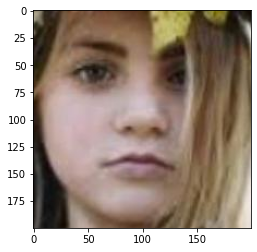

In [9]:
print(df['Ages'][3])
plt.imshow(df['Images'][3])

In [ ]:
plt.figure(figsize=(18,6))
plt.hist(df['Ages'],bins=100)
plt.show()

In [11]:
under_4=[]
for i in range(len(df)):
  if df['Ages'].iloc[i] <=4:
    under_4.append(df.iloc[i])
under_4=pd.DataFrame(under_4)
under_4=under_4.sample(frac=0.3)

up_4=df[df['Ages']>4]
df=pd.concat([under_4,up_4])


In [ ]:
plt.figure(figsize=(18,6))
plt.hist(df['Ages'],bins=100)
plt.show()

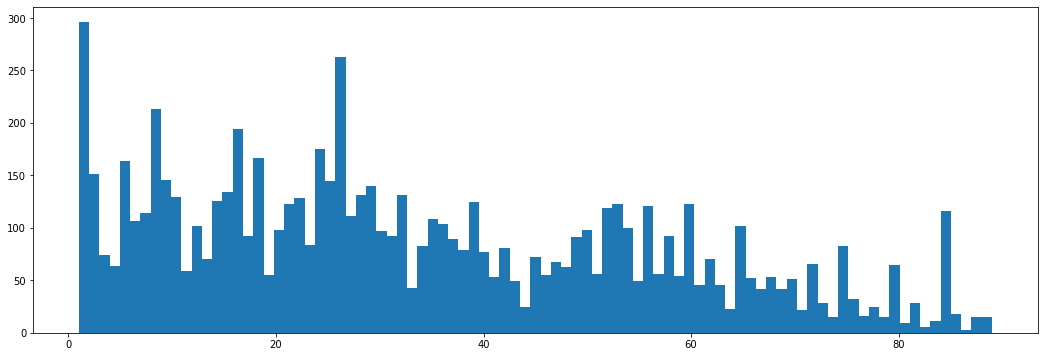

In [39]:
df=df[df['Ages']<90]
plt.figure(figsize=(18,6))
plt.hist(df['Ages'],bins=89)
plt.show()

In [ ]:
X=[]
Y=[]
for i in range(len(df)):
  df['Images'].iloc[i]=cv2.resize(df['Images'].iloc[i],(width,height))
  X.append(df['Images'].iloc[i])
  Y.append(df['Ages'].iloc[i])

X=np.array(X)
Y=np.array(Y)  

In [15]:
X.shape

(7545, 224, 224, 3)

In [16]:
x_train,x_val,y_train,y_val=train_test_split(X,Y,test_size=0.2)


In [17]:
data_generator=ImageDataGenerator(rescale=1./255,
                                  horizontal_flip=True)

train_data=data_generator.flow(x_train,y_train,batch_size=batch_size)

val_data=data_generator.flow(x_val,y_val,batch_size=batch_size)


In [ ]:
base_model=tf.keras.applications.MobileNetV2(
    input_shape=(width,height,3),
    weights='imagenet',
    include_top=False,
    pooling='avg'
)

In [19]:
for layer in base_model.layers[:-4]:
  layer.trainable=False

In [20]:
model=tf.keras.Sequential([
                           base_model,
                           Dense(1,activation='relu')
])

In [ ]:
model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=0.001))

In [ ]:
model.fit(train_data,validation_data=val_data,epochs=epochs,shuffle=True)

In [ ]:
model.save('Model_age.h5')

In [25]:
model=tf.keras.models.load_model('Model_age.h5')

In [ ]:
!pip install retina-face

In [27]:
from retinaface import RetinaFace
def process_and_predict(image_path):
  faces=RetinaFace.extract_faces(img_path=image_path,align=True)
  image=faces[0]

  image=cv2.resize(image,(width,height))
  plt.imshow(image)
  
  image=image/255.
  image=np.expand_dims(image,axis=0)

  age=model.predict(image)
  print(age)

[[28.393112]]


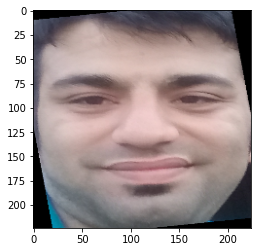

In [36]:
process_and_predict('1.jpg')